# Using SQL to analyze Chinook Database 

Using my knowledge in SQL I will demonstrate what I am able to do using a practice dataset that can be found online at https://github.com/lerocha/chinook-database

Most questions we will look to answer with this database have been given by dataquest from

## Setup

In [1]:
import sqlite3 #first importing all the libraries needed for this project.
import seaborn as sns
import numpy as np
import pandas as pd 

In [2]:
%%capture  
%load_ext sql
%sql sqlite:///chinook.db #connects us to the chinook.db file which contains our database.

Now that the connection to the database is made we can take a look at what it consists of.

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


As you can see our code returns a list with the name as well as type of each table in our dataset. If you continue down you can see a schema representing our database, with the primary keys being highlighted in yellow. As you may see, this databases is a representation of a digital media store, where customers can purchase tracks for a certain price.

Having a schema such as the one below is quite useful when coding as it provides a nice and easy way to see connections between different the different tables.

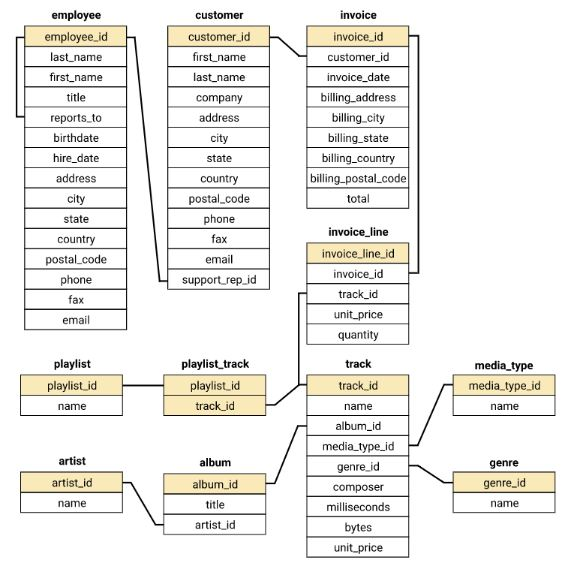

# Analysis of Most Popular Genres

For our first analysis we will aim to answer the following question: let's imagine we have four different artists wanting to release their first album on the platform. Each of the artist is releasing an album of a different genre:

Regal is releasing a Hip-Hop Album

Redtone is releasing a punk Album

Meteor and the Girls is releasing Pop Album

Slim Jim bites is releasing a blues Album.

We know the company (chinook) will want to advertize primarly in the USA, and that we can only have three out of the four artists have their albums on the platform. Which three should we choose to maximize income?

We will look at the most popular genres specifically in the USA, and then from that infer which three artists we believe will have the most success.

We aim to return a table that contains the top genres sold in America as well as the number of track sold per genre and by percentage.

In [33]:
%%sql

WITH tracks_sold_usa AS
    ( SELECT il.* FROM invoice_line il
     INNER JOIN invoice i on il.invoice_id = i.invoice_id
     INNER JOIN customer c on i.customer_id = c.customer_id
     WHERE c.country = 'USA'
    ) -- This subquery creates a table that contains all the tracks sold in the USA
SELECT 
       g.name genre,
       count(tsu.invoice_line_id) tracks_sold,
       cast(count(tsu.invoice_line_id) AS FLOAT) / (
            SELECT COUNT(*) from tracks_sold_usa
            ) percentage_sold 
FROM tracks_sold_usa tsu
INNER JOIN track t on t.track_id = tsu.track_id
INNER JOIN genre g on g.genre_id = t.genre_id 
GROUP BY 1 -- After having selected the columns we want, we group them by genre 
ORDER BY 2 DESC  
LIMIT 10; 



 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Pop,22,0.02093244529019981
Latin,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


According to the table here above, the three artists we should purchase the tracks from would be:Redtone(punk), Album Meteor and the Girls(Pop), Slim Jim bites(blues) as those 3 are seemingly more popular than Hip-Hop. Rock genre being that prevalent with more than half the sales is an interesting sidenote.

## Analysis of "best" sales employee

Next we will calculate how much money each sales support employee is bringing in. We will not only create a table with an employee's name and how much they have earned the company, but we will also include their hiring date as we expect newer employees to have sold less than older ones.

In [42]:
%%sql

WITH employee_sales AS
    (
     SELECT 
          i.customer_id,
          c.support_rep_id,
          sum(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 2
    )
SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    sum(es.total) total_sales
FROM employee_sales es
INNER JOIN employee e ON e.employee_id = es.support_rep_id
GROUP BY 1;


 * sqlite:///chinook.db
Done.


employee,hire_date,total_sales
Jane Peacock,2017-04-01 00:00:00,1731.510000000004
Margaret Park,2017-05-03 00:00:00,1584.0000000000032
Steve Johnson,2017-10-17 00:00:00,1393.9200000000028


We here have three employees, with Jane Peacock having most total sales at about 1731 which is about 150 higher than Margaret Park and 350 higher than Steve Johnson. However we have to pay in mind that Jane got hired first, about 1 month earlier than Margaret and 6 and a half months before Steve. 

As such it looks from this table that Steve seems to be better at making sales than Margaret. However external factors that this dataset does not provide could have impacted the sales number ( such as one of the employees being on an extended leave)

## ANALYSIS OF SALES BY COUNTRY

We now want to look at sales by country, more specifically we want to return a table which contains: total number of customers, total value of sales, average value of sales per customer, and average order value, all which will be grouped by country. We will also group all countries which have only one customer into an "other" category. 

In [63]:
%%sql

WITH other_category AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    ) -- This subquery creates a table where country with one customer are tagged as "other" in a new column
SELECT
    country,
    customer,
    total_sales,
    average_order,
    customer_lifetime_value -- getting all the columns we want to show
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customer, -- makes sure we do not have any duplicate customers
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id ) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0 
        END AS sort -- This will allow us below to sort by total_sales descending while having the other category at the bottom
    FROM other_category
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC 
    ); 
    

 * sqlite:///chinook.db
Done.


country,customer,total_sales,average_order,customer_lifetime_value
USA,13,1040.490000000008,7.942671755725252,80.03769230769292
Canada,8,535.5900000000034,7.047236842105309,66.94875000000043
Brazil,5,427.68000000000245,7.011147540983647,85.53600000000048
France,5,389.0700000000021,7.781400000000042,77.81400000000042
Germany,4,334.6200000000016,8.161463414634186,83.6550000000004
Czech Republic,2,273.24000000000103,9.108000000000034,136.62000000000052
United Kingdom,3,245.52000000000078,8.768571428571457,81.84000000000026
Portugal,2,185.13000000000022,6.3837931034482835,92.56500000000011
India,2,183.1500000000002,8.72142857142858,91.5750000000001
Other,15,1094.9400000000085,7.448571428571486,72.99600000000056


From this table we see that our digital store seems to be mostly used in the Western World. India is the only non western country to have more than 1 customer. We can also notice the Czech Republic having the highest customer lifetime value by quite a bit. We do have to note that the sample size is very small, and thus making any conclusion from this table should be made with a grain of salt.

## Analysis of Albums vs Individual Tracks.

In this section we are interested in whether customers buy whole albums or single tracks more. This analysis is important for the digital store business so they may have information as to whether they should themselves buy whole albums from artists or just the more popular tracks

In [64]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674


We see that about 18.5% of sales are made to buy the whole albums, therefore it would be strongly recommended to keep buying albums from artists as that is a significant part of the business income.